## **1. 필수 라이브러리 및 환경 설정**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# 1. 재현성을 위한 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# 2. GPU 설정 (Colab 상단 메뉴: 런타임 > 런타임 유형 변경 > T4 GPU 선택 필수)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")

현재 사용 중인 장치: cuda


## **2. 데이터셋 다운로드**

In [2]:
from google.colab import files

# 1. kaggle.json 파일 업로드 요청
print("kaggle.json 파일을 업로드해주세요.")
files.upload()

# 2. Kaggle API 설정 및 권한 부여
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. 데이터셋 다운로드 (theaayushbajaj/cbir-dataset)
print("데이터셋 다운로드를 시작합니다...")
!kaggle datasets download -d theaayushbajaj/cbir-dataset

# 4. 압축 해제
print("압축 해제 중...")
!unzip -q cbir-dataset.zip -d cbir_data
print("데이터 준비 완료!")

kaggle.json 파일을 업로드해주세요.


Saving kaggle.json to kaggle.json
데이터셋 다운로드를 시작합니다...
Dataset URL: https://www.kaggle.com/datasets/theaayushbajaj/cbir-dataset
License(s): unknown
 63% 145M/232M [00:00<00:00, 1.52GB/s]
100% 232M/232M [00:00<00:00, 947MB/s] 
압축 해제 중...
데이터 준비 완료!


## **3. 데이터 로더 (Data Loader)**

In [3]:
class CBIRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # jpg, png, jpeg 등 모든 이미지 파일을 재귀적으로 찾음
        self.image_paths = glob.glob(os.path.join(root_dir, '**', '*.jpg'), recursive=True) + \
                           glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True) + \
                           glob.glob(os.path.join(root_dir, '**', '*.jpeg'), recursive=True)
        self.transform = transform
        print(f"총 발견된 이미지 개수: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros(3, 128, 128) # 에러 시 검은색 이미지 반환

In [4]:
# 전처리 정의 (128x128 리사이즈)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 데이터셋 및 로더 인스턴스 생성
# 압축 해제된 폴더 경로 지정 ('cbir_data' 내부를 탐색)
dataset = CBIRDataset(root_dir='./cbir_data', transform=transform)

# 전체 데이터를 학습용으로 사용
# 여기서는 전체를 학습하고 전체에서 검색하는 방식으로 진행
BATCH_SIZE = 64
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

총 발견된 이미지 개수: 4738


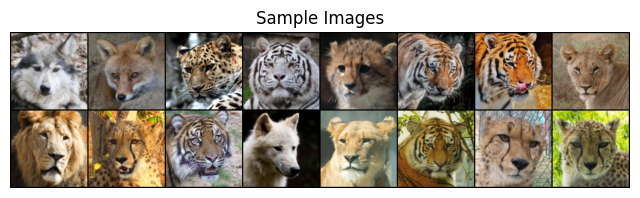

In [5]:
# 샘플 이미지 확인
sample_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(sample_batch[:16], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## **4. Convolutional Autoencoder (CAE) 모델 정의**

- Encoder: 이미지를 점점 줄여가며(Downsampling) 핵심 특징(Latent Feature)을 추출합니다.

- Decoder: 추출된 특징을 다시 원래 크기로 늘려가며(Upsampling) 이미지를 복원합니다.

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # [Encoder] : 128x128 -> 64x64 -> 32x32 -> 16x16 (압축)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # (3, 128, 128) -> (16, 64, 64)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (16, 64, 64) -> (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # (32, 32, 32) -> (64, 16, 16)
            nn.ReLU()
        )

        # [Decoder] : 16x16 -> 32x32 -> 64x64 -> 128x128 (복원)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # (64, 16, 16) -> (32, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (32, 32, 32) -> (16, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # (16, 64, 64) -> (3, 128, 128)
            nn.Sigmoid() # 픽셀 값 0~1 사이로 복원
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    # 특징 추출을 위한 편의 함수 (학습 후 사용)
    def get_latent_feature(self, x):
        with torch.no_grad():
            encoded = self.encoder(x)
            # (Batch, 64, 16, 16) -> (Batch, 64*16*16) = (Batch, 16384) 형태로 평탄화
            flattened = encoded.view(encoded.size(0), -1)
        return flattened

In [7]:
# 모델 생성 및 GPU 할당
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


## **5. 모델 학습 (Training Loop)**

> 오토인코더는 입력 이미지(Input)와 복원된 이미지(Output)가 최대한 똑같아지도록 학습합니다.

- 손실 함수(Loss): MSELoss (평균 제곱 오차)

- 최적화(Optimizer): Adam

- Epoch: 15회로 설정

In [8]:
# 하이퍼파라미터 설정
num_epochs = 15
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# 학습 시작
print("학습을 시작합니다...")
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # 데이터 로더에서 배치 단위로 이미지 가져오기
    for images in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # 이미지를 GPU로 이동
        images = images.to(device)

        # 오토인코더는 입력이 곧 정답(Target)입니다.
        outputs = model(images)
        loss = criterion(outputs, images) # 복원 오차 계산

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 에폭별 평균 Loss 출력
    epoch_loss = running_loss / len(data_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("학습 완료!")

학습을 시작합니다...


Epoch 1/15: 100%|██████████| 75/75 [00:21<00:00,  3.42it/s]


Epoch [1/15], Loss: 0.0318


Epoch 2/15: 100%|██████████| 75/75 [00:26<00:00,  2.83it/s]


Epoch [2/15], Loss: 0.0126


Epoch 3/15: 100%|██████████| 75/75 [00:26<00:00,  2.80it/s]


Epoch [3/15], Loss: 0.0097


Epoch 4/15: 100%|██████████| 75/75 [00:23<00:00,  3.22it/s]


Epoch [4/15], Loss: 0.0083


Epoch 5/15: 100%|██████████| 75/75 [00:24<00:00,  3.12it/s]


Epoch [5/15], Loss: 0.0068


Epoch 6/15: 100%|██████████| 75/75 [00:26<00:00,  2.82it/s]


Epoch [6/15], Loss: 0.0062


Epoch 7/15: 100%|██████████| 75/75 [00:20<00:00,  3.63it/s]


Epoch [7/15], Loss: 0.0057


Epoch 8/15: 100%|██████████| 75/75 [00:20<00:00,  3.70it/s]


Epoch [8/15], Loss: 0.0054


Epoch 9/15: 100%|██████████| 75/75 [00:19<00:00,  3.80it/s]


Epoch [9/15], Loss: 0.0050


Epoch 10/15: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch [10/15], Loss: 0.0048


Epoch 11/15: 100%|██████████| 75/75 [00:24<00:00,  3.01it/s]


Epoch [11/15], Loss: 0.0046


Epoch 12/15: 100%|██████████| 75/75 [00:24<00:00,  3.04it/s]


Epoch [12/15], Loss: 0.0043


Epoch 13/15: 100%|██████████| 75/75 [00:24<00:00,  3.10it/s]


Epoch [13/15], Loss: 0.0041


Epoch 14/15: 100%|██████████| 75/75 [00:20<00:00,  3.62it/s]


Epoch [14/15], Loss: 0.0040


Epoch 15/15: 100%|██████████| 75/75 [00:20<00:00,  3.67it/s]

Epoch [15/15], Loss: 0.0039
학습 완료!


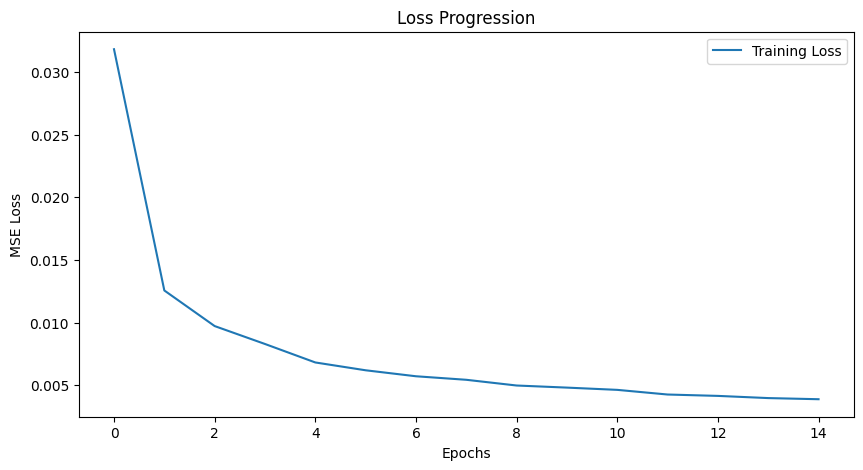

In [10]:
# 학습 결과(Loss 감소) 시각화
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

## **6. 전체 이미지의 특징(Latent Feature) 추출**
> 이 단계에서는 모델의 Decoder(복원) 부분은 버리고, Encoder(압축) 부분만 사용합니다. 모든 이미지를 Encoder에 통과시켜 나온 결과값(Vector)을 리스트에 저장해 "검색용 데이터베이스"를 만듭니다.

- 주의: 나중에 원본 이미지를 보여주기 위해, DataLoader의 shuffle=False 설정이 중요합니다. (인덱스 순서 유지)

In [11]:
# 1. 평가 모드로 전환 (Dropout, BatchNorm 등의 동작 고정)
model.eval()

# 2. 순서가 섞이지 않은 DataLoader 생성 (이미지 경로와 특징 벡터를 매칭하기 위해)
feature_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# 특징 벡터와 이미지 경로를 저장할 리스트
feature_list = []
image_paths = []

print("전체 이미지의 특징을 추출하고 있습니다...")

with torch.no_grad(): # 그래디언트 계산 비활성화 (메모리 절약)
    for images in tqdm(feature_loader, desc="Extracting Features"):
        images = images.to(device)

        # Encoder만 통과시킴
        encoded = model.encoder(images)

        # (Batch, 64, 16, 16) 형태의 4차원 텐서를 (Batch, 16384) 형태의 1차원 벡터로 변환
        # 64(채널) * 16(가로) * 16(세로) = 16384 차원의 특징 벡터
        flattened = encoded.view(encoded.size(0), -1)

        # CPU로 이동 후 Numpy 배열로 변환하여 저장
        feature_list.append(flattened.cpu().numpy())

# 리스트를 하나의 큰 Numpy 배열로 합치기
features_db = np.concatenate(feature_list, axis=0)

# 이미지 경로 저장 (dataset 내부의 파일 리스트)
image_paths = dataset.image_paths

print(f"\n특징 추출 완료!")
print(f"데이터베이스 크기: {features_db.shape}")

전체 이미지의 특징을 추출하고 있습니다...


Extracting Features: 100%|██████████| 75/75 [00:18<00:00,  3.95it/s]


특징 추출 완료!
데이터베이스 크기: (4738, 16384)


## **7. 유사 이미지 검색 및 시각화 (Top-K Retrieval)**

이제 features_db에서 Query 이미지와 가장 가까운 벡터를 찾습니다. 가장 보편적인 유클리드 거리(Euclidean Distance) 또는 코사인 유사도를 사용할 수 있는데, 여기서는 scikit-learn의 NearestNeighbors를 사용하여 빠르고 간편하게 구현합니다.

In [12]:
from sklearn.neighbors import NearestNeighbors

In [13]:
# 1. 검색 엔진 설정 (유클리드 거리 기준)
# n_neighbors=6 인 이유: 자기 자신(거리 0)이 1등으로 나오기 때문에, 자기 자신 포함 상위 6개를 뽑습니다.
knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
knn.fit(features_db)

def search_and_visualize(query_idx):
    """
    데이터셋 내의 특정 인덱스(query_idx) 이미지를 Query로 사용하여
    가장 유사한 이미지 5장을 시각화합니다.
    """

    # Query 이미지의 특징 벡터 가져오기
    query_feature = features_db[query_idx].reshape(1, -1)

    # 검색 실행 (거리와 인덱스 반환)
    distances, indices = knn.kneighbors(query_feature)

    # 결과 시각화
    plt.figure(figsize=(15, 5))

    # 결과 출력 (첫 번째는 Query 이미지, 그 뒤로 유사한 이미지들)
    for i in range(6):
        found_idx = indices[0][i]
        dist = distances[0][i]

        # 이미지 로드
        img_path = image_paths[found_idx]
        img = Image.open(img_path).convert("RGB")

        ax = plt.subplot(1, 6, i + 1)

        if i == 0:
            ax.set_title("Query Image", color='red', fontsize=14, fontweight='bold')
            # 테두리 강조 (Query)
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
        else:
            ax.set_title(f"Rank {i}\nDist: {dist:.4f}", fontsize=10)

        plt.imshow(img)
        plt.axis('off')

    plt.show()

랜덤 이미지 검색 테스트를 진행합니다...


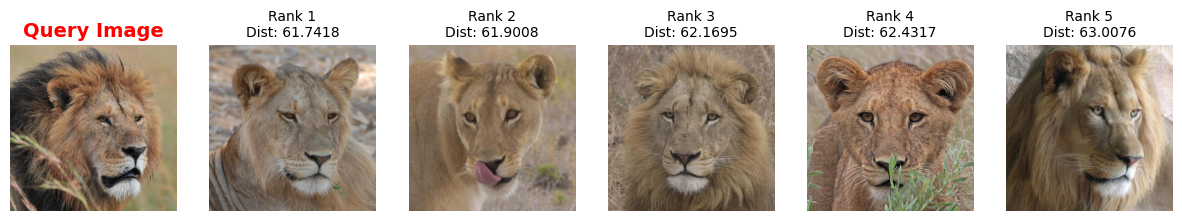

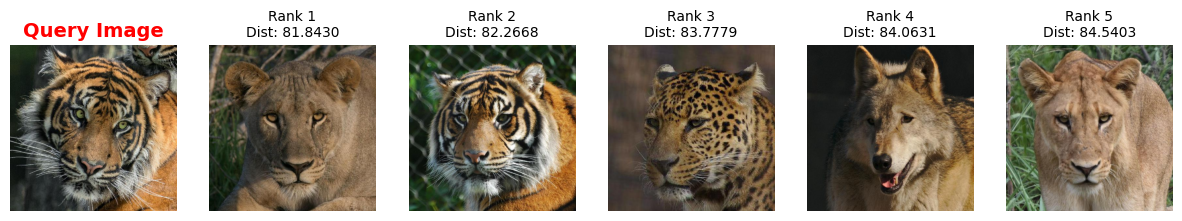

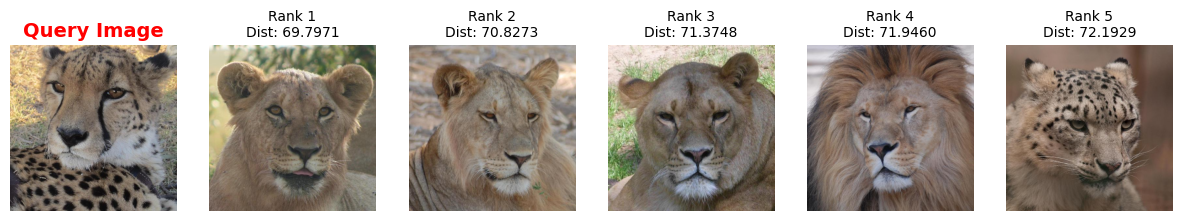

In [14]:
# --- 테스트 실행 ---
# 랜덤으로 테스트할 이미지 3장을 뽑아서 검색 결과 확인
import random

print("랜덤 이미지 검색 테스트를 진행합니다...")
random_indices = random.sample(range(len(image_paths)), 3)

for idx in random_indices:
    search_and_visualize(idx)